<a name="top"></a>
<div style="width:1000 px">

<div style="float:right; width:98 px; height:98px;">
<img src="https://cdn.miami.edu/_assets-common/images/system/um-logo-gray-bg.png" alt="Miami Logo" style="height: 98px;">
</div>

<h1>May 3, 2019 -- Lunch Bytes</h1>
<h2><i>Switching to Python:</i> Computation and Stat Basics for Matlab and NCL Converts</h2>
<br>Kelsey Malloy
    
<br>
<br>
<h3>Today's Objectives:</h3>
<br>1. Demonstrate chaos theory using Lorenz equations
<br>2. Show PDF/KDE shift in Florida daily average temperature
<br>3. Investigate linear relationship between Florida max temperatures and ENSO
<br>
<h3>Inputs:</h3>
<br>tmax_79_98.nc --> pre-processed Florida daily-avg temperatures between 1979-1998
<br>tmax_99_18.nc --> "" "" "" " " " " " " " " " " "" " " " " " " " " " " 1999-2018
<br>EN34_05.nc --> pre-processed, standardized monthly May El Nino 3.4 index between 1980-2017
<br>(see more about processing data in GettingData.ipynb)
<br>
<h3>Outputs:</h3>
<br>Two Lorenz butterflies, before and after perturbed initial conditions
<br>KDE of 1975-1995 and 1996-2016 daily-avg Florida temperature
<br>Linear regression figure with ENSO time series regressed onto Florida temps
<br>
<br>
<i>last edited: 04/30/2019



<div style="clear:both"></div>
</div>

<hr style="height:2px;">

In [28]:
# let's import some libraries
import xarray as xr
import numpy as np
import pandas as pd
import netCDF4 as nc
from scipy.integrate import odeint 
import scipy.ndimage
import matplotlib.pyplot as plt
import matplotlib as mpl
import netCDF4 as nc
import mpl_toolkits
from mpl_toolkits.basemap import Basemap
from mpl_toolkits import mplot3d

<i> Lorenz (1963) -- code transcribed from ATM713's matlab code

In [64]:
# defining our Lorenz equations
def f(y, t, params):
    y1, y2, y3 = y      # unpack current values of y
    r, sigma, b = params  # unpack parameters
    derivs = [sigma*(y2-y1),(r*y1)-y2-(y1*y3),(y1*y2)-(b*y3)]
    return derivs

In [65]:
# set our parameters
sigma = 10. # putting '.' at end ensures the number is a float
b = 8./3.
r = 28.
params = [r, sigma, b] # package for ODE solver

# set our initial conditions
y1 = -1.
y2 = 3.
y3 = 4.
y = [y1,y2,y3] # package for ODE solver

#### np.linspace similar to Matlab linspace, makes array as (start_pt,end_pt,number_of_intervals)
#### np.arange makes array as (start_pt, end_pt + step_size, step_size)

In [66]:
# Make time array for solution
tStart = 0 # start
tEnd = 50  # end
Nt = 10000 # number of intervals you want
t = np.linspace(tStart,tEnd,Nt)

<h4> This ODE solver similar to Matlab's "odeset"</h4>
<br> There are actually multiple ODE solvers out there for Python, but we will use odeint today.

Text(0.5, 0.92, '3-D Lorenz Butterfly\n')

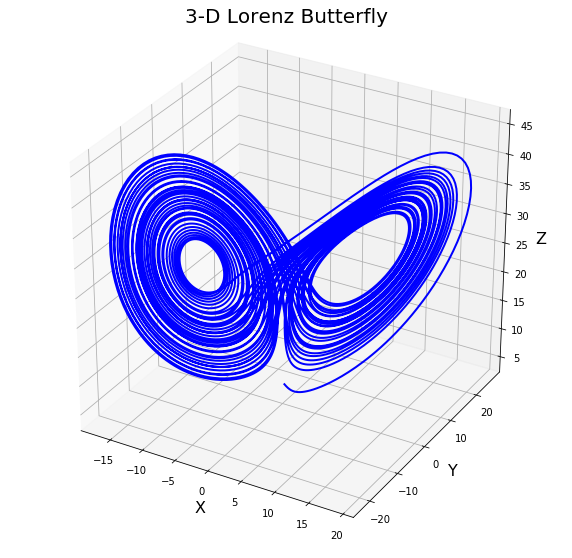

In [67]:
# Call the ODE solver
soln = odeint(f, y, t, args=(params,)) # output: 1st axis are solutions at each time step; 2nd axis is dimension (x,y,z)

# Plot
fig = plt.figure(figsize=[10,10])

# Plot 3d plane of x,y,z
ax = plt.axes(projection='3d')
ax.plot3D(soln[:,0],soln[:,1],soln[:,2],color='b',linewidth=2)
ax.set_xlabel('X',fontsize=16)
ax.set_ylabel('Y',fontsize=16)
ax.set_zlabel('Z',fontsize=16)
ax.set_title('3-D Lorenz Butterfly\n',fontsize=20)

<h4>Now add a very small pertubation to our initial conditions...</h4>

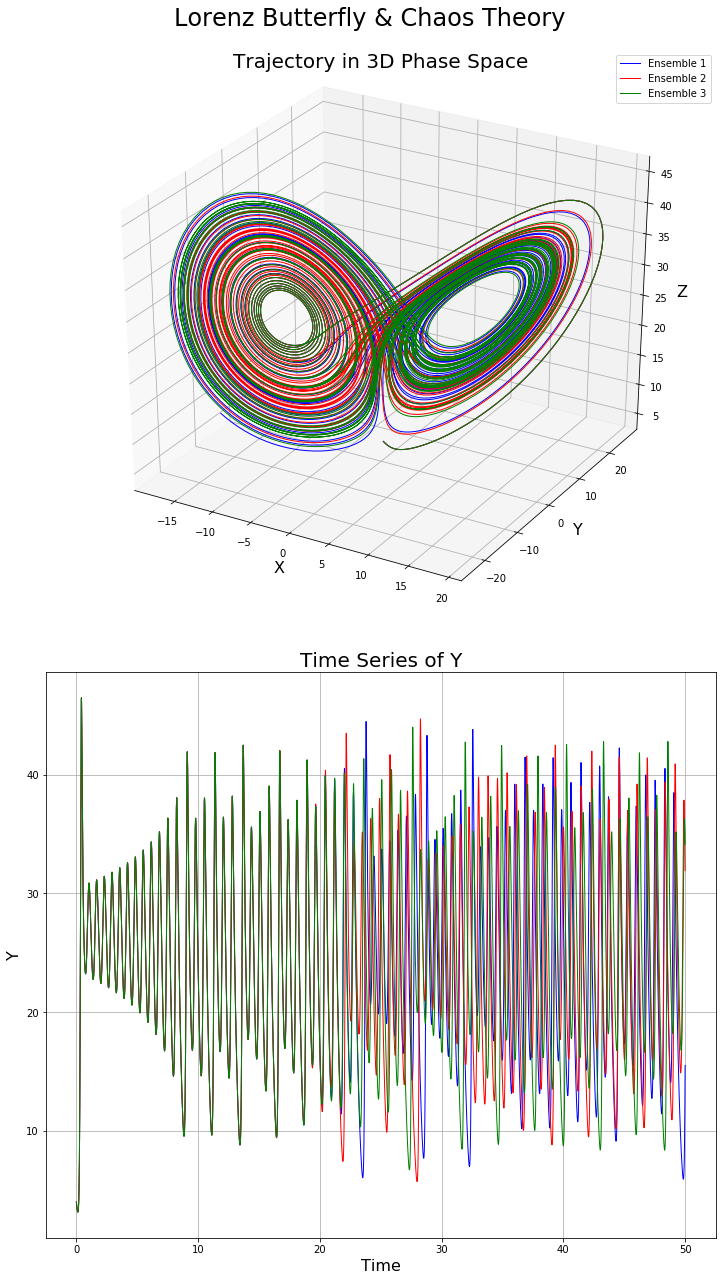

In [68]:
eps = 10**-8. # perturbation

ens1 = [y[0]+eps,y[1],y[2]]
ens2 = [y[0],y[1]+eps,y[2]]
ens3 = [y[0],y[1],y[2]+eps]

# these act like our ensembles
ensset = [ens1,ens2,ens3]
ens_labels = ['Ensemble 1','Ensemble 2','Ensemble 3'] # corres. labels
ens_colors = ['b','r','g'] # corres. colors

# Setup figure before loop
fig = plt.figure(figsize=[12,20])
st = fig.suptitle('Lorenz Butterfly & Chaos Theory', fontsize=24)

ax1 = fig.add_subplot(211,projection='3d')
ax1.set_xlabel('X',fontsize=16)
ax1.set_ylabel('Y',fontsize=16)
ax1.set_zlabel('Z',fontsize=16)
ax1.set_title('Trajectory in 3D Phase Space\n',fontsize=20)

# plot timeseries of y
ax2 = fig.add_subplot(212)
ax2.set_xlabel('Time',fontsize=16)
ax2.set_ylabel('Y',fontsize=16)
ax2.set_title('Time Series of Y',fontsize=20)
plt.grid(True)

# enumerate() allows you to loop through index and its element
for idx, ens in enumerate(ensset): # loop through our ensembles
    enssoln = odeint(f,ens,t,args=(params,))
    #solnset.append(enssoln) # add ensemble to array without overwriting
    
    # add to axis 1
    ax1.plot(enssoln[:,0],enssoln[:,1],enssoln[:,2],label=ens_labels[idx],color=ens_colors[idx],linewidth=1)
    
    # add to axis 2
    ax2.plot(t,enssoln[:,2],label=ens_labels[idx],color=ens_colors[idx],linewidth=1)
   
ax1.legend(loc=0) # loc=0 means approx. best placement
plt.subplots_adjust(top=0.95,wspace=0.1, hspace=0.1) # more attributes for control 
st.set_y(0.98)

<h4>Well that is pretty cool! The lines seem to overlap until a certain time, then they diverge... initial perturbations
    grow in time! :)</h4>
    
<hr style="height:2px;">

### Okay, your anti-science uncle from Orlando wants to know why he should care about climate change. He says, "It is always hot in Florida -- I feel no difference!" You disagree, of course. But now you need the evidence to back it up.

In [41]:
# let's load some daily max temperature data for Florida
tmax_earlier = xr.open_dataset('tmax_79_98.nc').tmax.values  # already celsius
tmax_later = xr.open_dataset('tmax_99_18.nc').tmax.values 

# you don't have to mask data necessarily if already NaN value
# this is good practice since masked arrays have new boolean attributes, and have their own math functions (helpful for lin alg)
tmax_earlier = np.ma.masked_invalid(np.array(tmax_earlier))
tmax_later = np.ma.masked_invalid(np.array(tmax_later))

# reshaping b/c each sample set includes daily tmax at each Florida gridpoint
[timex, latx, lonx] = np.shape(tmax_earlier) # get shape dimensions, check that both arrays are same time length
tmax_earlier = np.ma.reshape(tmax_earlier,(timex*latx*lonx))
tmax_later = np.ma.reshape(tmax_later,(timex*latx*lonx))

print(tmax_earlier.min(),tmax_earlier.max(),tmax_later.min(),tmax_later.max())

-14.842658 45.85803 -32.346394 43.434635


C:\Users\kelse\Anaconda3\envs\LB_20190503\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\kelse\Anaconda3\envs\LB_20190503\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


Text(0.5, 0, 'Temp, $^\\circ$C')

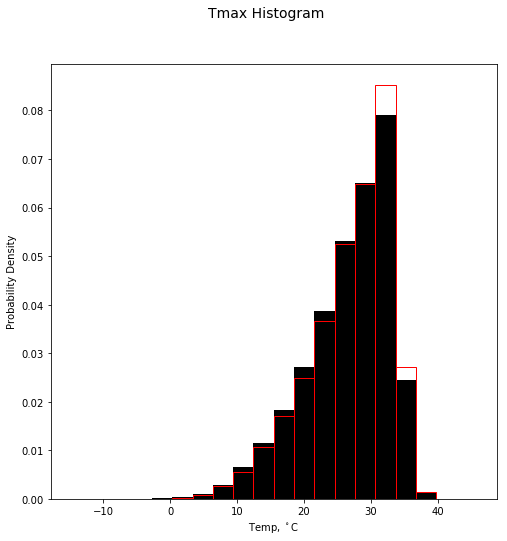

In [42]:
fig = plt.figure(figsize=[8,8])
st = fig.suptitle('Tmax Histogram', fontsize=14)

ax1 = fig.add_subplot(111)
ax1.hist(tmax_earlier,bins=20,range=(tmax_earlier.min(),tmax_earlier.max()),density=True,fill=True,color='black')
ax1.hist(tmax_later,bins=20,range=(tmax_earlier.min(),tmax_earlier.max()),density=True,fill=False,edgecolor='red')
ax1.set_ylabel('Probability Density')
ax1.set_xlabel('Temp, $^\circ$C')

### Can't see shift that well with this histogram, so let's do a PDF fit
#### It doesn't look like a normal distribution, so let's use a kernel density estimator

In [43]:
# let's just work with filtered data, b/c otherwise a lot of data to compute in our Lunch Bytes hour
# Xarray seems best library for grouping
tmax_earlier_s = xr.open_dataset('tmax_79_98.nc').tmax
tmax_later_s = xr.open_dataset('tmax_99_18.nc').tmax
seasons = list(tmax_earlier_s.groupby('time.season').groups)

print(seasons)

['DJF', 'JJA', 'MAM', 'SON']


In [44]:
# I am going to define a function that takes a xarray Dataset that is grouped, 
# turn it into a numpy array of selected group's values
def groupedxr_to_nparray(data,dim,group):
    indices = data.groupby(dim).groups[group]
    vals = np.array(data[indices])
    
    return vals

DJF
JJA
MAM
SON
Wall time: 1min 38s


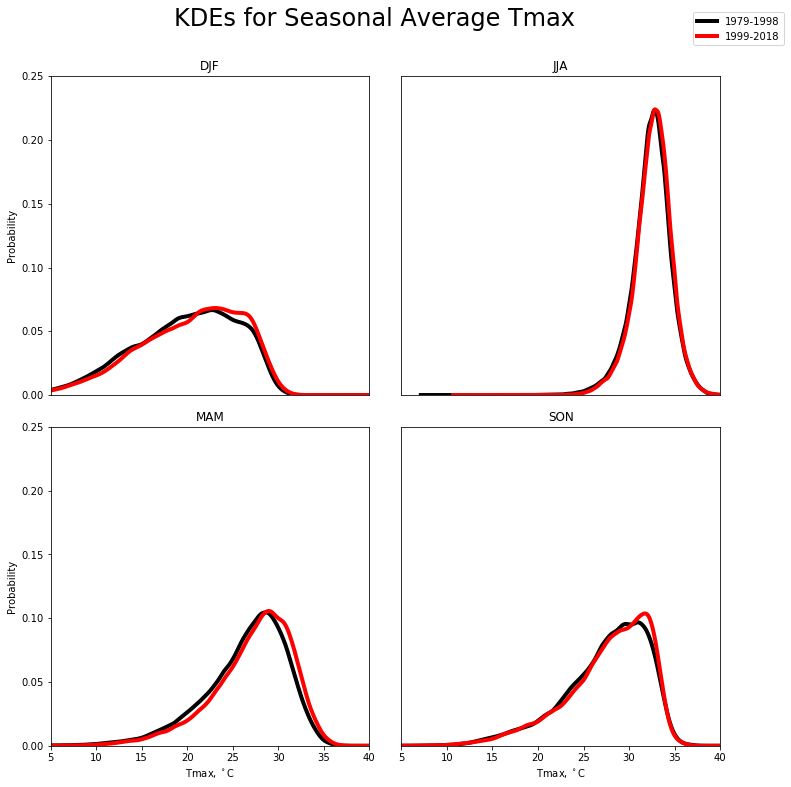

In [45]:
%%time
# Pandas package is a good way to make a DataFrame and label your own data for easy plotting!

fig = plt.figure(figsize=[12,12])
st = fig.suptitle('KDEs for Seasonal Average Tmax', fontsize=24)

for i, season in enumerate(seasons):
    print(season)
    ax = fig.add_subplot(2,2,i+1) # now I'm getting fancy with my loops, adding to my 2x2 panel 
    
    vals_earlier = groupedxr_to_nparray(tmax_earlier_s,'time.season',season) # calling my function
    vals_later = groupedxr_to_nparray(tmax_later_s,'time.season',season)
    t,y,x=vals_earlier.shape
    vals_earlier = vals_earlier.reshape([t*y*x]) # I want it to be 1-D for pandas, note that I could have added this step in function
    vals_later = vals_later.reshape([t*x*y])
    
    tmax_earlier_tmp = pd.DataFrame(vals_earlier,columns=['1979-1998'])
    tmax_later_tmp = pd.DataFrame(vals_later,columns=['1999-2018'])
    
    tmax_earlier_tmp.plot.kde(ax=ax,color='k',linewidth=4)
    tmax_later_tmp.plot.kde(ax=ax,color='r',linewidth=4)
    
    ax.set_title(season)
    ax.set_ylim([0,.25]) # should fix the axes so that they can be read the same
    ax.set_xlim([5,40])
    
    # each panel gets its own attributes (can be a function)
    if i == 0: 
        ax.set_ylabel('Probability')
        ax.set_xticks([])
        ax.get_legend().remove()
    elif i == 1:
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_ylabel('')
        ax.legend(loc='upper right', bbox_to_anchor= (1.2, 1.2), ncol=1, 
            borderaxespad=0, frameon=True)
    elif i == 2:
        ax.set_xlabel('Tmax, $^\circ$C')
        ax.set_ylabel('Probability')
        ax.get_legend().remove()
    elif i == 3:
        ax.set_yticks([])
        ax.set_xlabel('Tmax, $^\circ$C')
        ax.set_ylabel('')
        ax.get_legend().remove()
   
plt.subplots_adjust(top=0.9,wspace=0.1, hspace=0.1) # more attributes
st.set_y(0.98)

<h4>Would you look at that... there is a distribution shift for every season to the right, especially for winter, spring, and fall. Florida seems to be getting warmer. </h4>

<h4> Bonus: try to do this at home, looking at tmin! I included the file in this directory for you.</h4>
    
<hr style="height:2px;">

## Finally, let's see how El Nino may affect Florida maximum temperatures this month

<img src="https://www.cpc.ncep.noaa.gov/products/analysis_monitoring/enso_update/ssta_c.gif" alt="ENSO outlook" style="height: 400px;">

In [2]:
# load El Nino 3.4 data I have processed and standardized for you
EN34file = open('EN34_05.txt','r')
EN34_data = EN34file.read().splitlines() # gets rid of line breaks
EN34_data = np.array(EN34_data,dtype=float) # making it a numpy array because we will be doing some matrix stuff
EN34_data # lets take a look

array([ 0.782145,  0.713586,  0.772003,  1.507525, -1.060484, -1.674425,
       -0.916064,  1.073511, -1.821883, -1.432854,  0.14977 ,  0.531496,
        1.776192,  1.347452,  0.594245, -0.099161, -0.63296 ,  1.062252,
        1.18687 , -1.851026, -1.363462, -0.499523,  0.519492, -0.889562,
        0.137938,  0.578795, -0.083427, -0.622503, -1.320084,  0.15553 ,
       -0.234734, -0.935437, -0.402365, -0.557326,  0.515666,  1.497085,
        0.782145,  0.713586])

In [46]:
# load in the May tmax data and concatenate the files
tmax_earlier = xr.open_dataset('tmax_79_98.nc').tmax
tmax_later = xr.open_dataset('tmax_99_18.nc').tmax
tmax = xr.concat([tmax_earlier,tmax_later],dim='time') # combine them over the time dimension, other dims must be the same
print(tmax.shape,tmax_earlier.shape) # should see double time dim

(14610, 16, 18) (7305, 16, 18)


In [47]:
# We want to only get years 1980-2017 because that is the length of EN 3.4 data
years = list(tmax.groupby('time.year').groups)[1:-1]
print(years) # check to see if 1980-2017
days=np.arange(1,31+1,1)

# for loops for xarray and pandas are slow, so filling numpy arrays may be best; however, I still use the attributes of our dataset
tmax_final=np.empty((len(years),len(tmax[0,:,0]),len(tmax[0,0,:])))
for year in years:
    tmax_monthly = np.empty((31,len(tmax[0,:,0]),len(tmax[0,0,:])))
    for day in days:
        tmax_tmp = tmax.sel(time=str(year)+'-05-'+str(day)) # select according to year and day, but constant month
        tmax_monthly[day-1,:,:] = tmax_tmp # fill data
    tmax_monthly = np.nanmean(tmax_monthly,axis=0)
    tmax_final[year-1980,:,:] = tmax_monthly
    
tmax_final.shape

[1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]


C:\Users\kelse\Anaconda3\envs\LB_20190503\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


(38, 16, 18)

<h4> Least Squares Method</h4>
<img src="https://www.saedsayad.com/images/MLR_2.png" alt="least squares" style="height: 200px;">

In [48]:
# reshape

[timex,latx,lonx] = tmax_final.shape # get in dimensions of time by space
tmax = tmax_final.reshape([timex,latx*lonx])
tmax.shape

(38, 288)

In [49]:
# compute variance -- this is essentially the denominator of least squares
tmax = np.ma.masked_invalid(tmax)
tmax_anom = np.ma.anom(tmax,axis=0)
print(tmax_anom.shape)

tmax_anom_T = np.ma.transpose(tmax_anom)
print(tmax_anom_T.shape)

tmax_var = np.ma.dot(tmax_anom_T,tmax_anom)
print(tmax_var.shape)

(38, 288)
(288, 38)
(288, 288)


In [50]:
# Computing the linear regression

tmax_cov = np.ma.dot(tmax_anom_T,EN34_data)
print(tmax_cov.shape)

tmax_reg = np.linalg.lstsq(tmax_var,tmax_cov) # returns residuals too so only axis 0 is least squares
tmax_reg = tmax_reg[0]

# put back into lat and lon
tmax_reg = tmax_reg.reshape([latx,lonx])
print(tmax_reg.shape)

# lastly, I am going to compare it to smoothed data (cubic spline method)
tmax_reg_smoothed = scipy.ndimage.zoom(tmax_reg, 3)

(288,)
(16, 18)


C:\Users\kelse\Anaconda3\envs\LB_20190503\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  


In [52]:
# create function for mapping domain
def Map_Florida():
    m = Basemap(projection='cyl', llcrnrlon=360-87, \
      urcrnrlon=360-79,llcrnrlat=24,urcrnrlat=31, \
      resolution='l')
    m.drawcoastlines(linewidth=1.5)
    m.drawstates(linewidth=1)
    m.drawlsmask(ocean_color='LightCyan')
    parallels = np.arange(20,80,10)
    meridians = np.arange(360-160,360-30,10)
    #m.drawparallels(parallels,labels=[1,0,0,0])
    #m.drawmeridians(meridians,labels=[0,0,0,1])
    return m

# mapping functions are your friend! If you create a figure that has a desired format for multiple plots, create a function
# (only created one for domain here since I have one subplot; Kayla's notebook has another example)

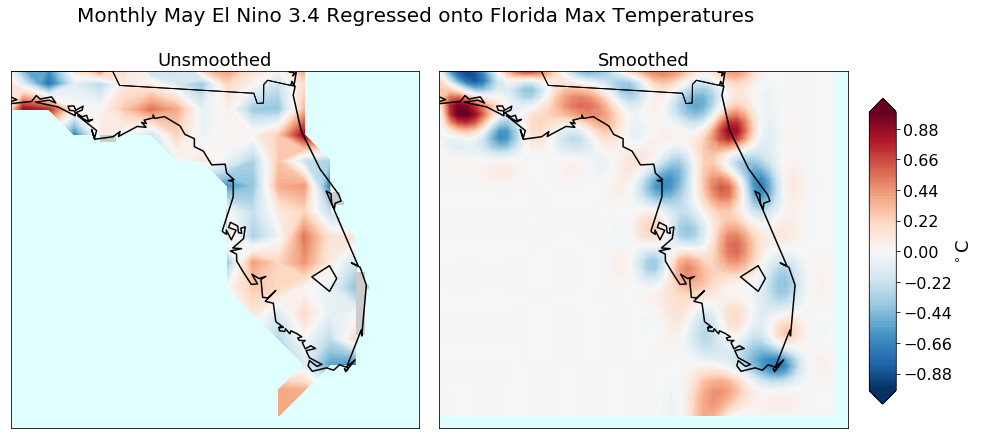

In [53]:
## PLOTTING

# parameters for plotting
cmap = 'RdBu_r'
levels = np.arange(-1,1+.02,.02)
# need lat and lon for grid
lat = xr.open_dataset('tmax_79_98.nc').lat
lon = xr.open_dataset('tmax_79_98.nc').lon
lat_smoothed = scipy.ndimage.zoom(lat, 3)
lon_smoothed = scipy.ndimage.zoom(lon, 3)


fig = plt.figure(figsize=[15,8.5])
st = fig.suptitle('Monthly May El Nino 3.4 Regressed onto Florida Max Temperatures', fontsize=20)

ax1 = fig.add_subplot(121)
m = Map_Florida()
x,y=m(*np.meshgrid(lon,lat))
cv = m.contourf(x, y, tmax_reg, levels, cmap=cmap, extend='both')
ax1.set_title('Unsmoothed',fontsize=18)

ax2 = fig.add_subplot(122)
m = Map_Florida()
x,y=m(*np.meshgrid(lon_smoothed,lat_smoothed))
cv2 = m.contourf(x, y, tmax_reg_smoothed, levels, cmap=cmap, extend='both')
ax2.set_title('Smoothed',fontsize=18)

cbaxes = fig.add_axes([0.92, 0.25, 0.025, 0.5])
cb = plt.colorbar(cv,orientation='vertical', cax = cbaxes)
cb.ax.set_ylabel('$^\circ$C',fontsize=18)
cb.ax.tick_params(labelsize=16)

plt.subplots_adjust(top=0.88,wspace=0.05, hspace=0.05)
st.set_y(0.9)


#### The above pattern of max temperature change is linearly associated with one positive standard deviation anomaly of El Nino 3.4 (warm phase).